## 1. Setup dan Import Library

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import warnings
import onnxmltools
from onnxmltools.convert.common.data_types import FloatTensorType
import onnx
import onnxruntime as ort
import os
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

## 2. Load Data 

In [2]:
data_path = '../data/processed/daily_trends_processed_20251221_183209.csv'

df = pd.read_csv(data_path)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['keyword', 'category', 'date'])

print(f"Shape data: {df.shape}")
print(f"Rentang tanggal: {df['date'].min()} sampai {df['date'].max()}")
print(f"Jumlah keywords: {df['keyword'].nunique()}")
print(f"Jumlah categories: {df['category'].nunique()}")

df.head()

Shape data: (4600, 14)
Rentang tanggal: 2025-09-19 00:00:00 sampai 2025-12-21 00:00:00
Jumlah keywords: 50
Jumlah categories: 10


,keyword,category,region,date,interest_value,day_of_week,is_holiday,holiday_name,year,month,week,day,dayofweek,is_weekend
0,beasiswa,Education & Career,ID,2025-09-21,80,Sunday,False,NaN,2025,9,38,21,6,True
1,beasiswa,Education & Career,ID,2025-09-22,93,Monday,False,NaN,2025,9,39,22,0,False
2,beasiswa,Education & Career,ID,2025-09-23,89,Tuesday,False,NaN,2025,9,39,23,1,False
3,beasiswa,Education & Career,ID,2025-09-24,89,Wednesday,False,NaN,2025,9,39,24,2,False
4,beasiswa,Education & Career,ID,2025-09-25,86,Thursday,False,NaN,2025,9,39,25,3,False


## 3. Feature Engineering

In [3]:
def create_features_7day(df):
    df = df.copy()
    
    # Time-based features
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    
    # Lag features
    for lag in [1, 2, 3, 7, 14]:
        df[f'lag_{lag}'] = df.groupby(['keyword', 'category'])['interest_value'].shift(lag)
    
    # Rolling statistics
    for window in [7, 14]:
        df[f'rolling_mean_{window}'] = df.groupby(['keyword', 'category'])['interest_value'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        df[f'rolling_std_{window}'] = df.groupby(['keyword', 'category'])['interest_value'].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )
        df[f'rolling_max_{window}'] = df.groupby(['keyword', 'category'])['interest_value'].transform(
            lambda x: x.rolling(window=window, min_periods=1).max()
        )
        df[f'rolling_min_{window}'] = df.groupby(['keyword', 'category'])['interest_value'].transform(
            lambda x: x.rolling(window=window, min_periods=1).min()
        )
    
    # Trend features
    df['diff_1'] = df.groupby(['keyword', 'category'])['interest_value'].diff(1)
    df['diff_7'] = df.groupby(['keyword', 'category'])['interest_value'].diff(7)
    
    # Target
    df['target_7d'] = df.groupby(['keyword', 'category'])['interest_value'].shift(-7)
    
    return df

df = create_features_7day(df)
df = df.dropna(subset=['lag_14', 'target_7d'])

print(f"Features berhasil dibuat. Shape baru: {df.shape}")
print(f"Jumlah kolom features: {df.shape[1]}")
print(f"Rentang tanggal valid: {df['date'].min()} sampai {df['date'].max()}")

Features berhasil dibuat. Shape baru: (3550, 32)
Jumlah kolom features: 32
Rentang tanggal valid: 2025-10-03 00:00:00 sampai 2025-12-14 00:00:00


## 4. Train/Test Split

In [4]:
feature_cols = [
    'day', 'month', 'year', 'dayofweek', 'quarter', 'weekofyear', 'is_weekend',
    'lag_1', 'lag_2', 'lag_3', 'lag_7', 'lag_14',
    'rolling_mean_7', 'rolling_mean_14',
    'rolling_std_7', 'rolling_std_14',
    'rolling_max_7', 'rolling_max_14',
    'rolling_min_7', 'rolling_min_14',
    'diff_1', 'diff_7'
]
categorical_features = ['keyword', 'category']

for col in categorical_features:
    if col in df.columns:
        df[col] = df[col].astype('category')

split_date = df['date'].quantile(0.8)
train_df = df[df['date'] < split_date]
test_df = df[df['date'] >= split_date]

X_train = train_df[feature_cols + categorical_features]
y_train = train_df['target_7d']

X_test = test_df[feature_cols + categorical_features]
y_test = test_df['target_7d']

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Train set: 2810 samples
Test set: 740 samples


## 5. Training Model LightGBM

In [7]:
params_cv = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 15,              
    'max_depth': 5,                
    'learning_rate': 0.01,         
    'feature_fraction': 0.6,       
    'bagging_fraction': 0.6,       
    'bagging_freq': 5,
    'min_child_samples': 30,       
    'min_data_in_leaf': 20,        
    'reg_alpha': 1.0,              
    'reg_lambda': 1.0,             
    'verbose': -1,
    'random_state': 42
}

# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []
cv_details = []

X_full = df[feature_cols + categorical_features]
y_full = df['target_7d']

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_full), 1):
    # Split data
    X_train_cv = X_full.iloc[train_idx]
    y_train_cv = y_full.iloc[train_idx]
    X_val_cv = X_full.iloc[val_idx]
    y_val_cv = y_full.iloc[val_idx]
    
    # Create datasets
    train_data_cv = lgb.Dataset(X_train_cv, label=y_train_cv, 
                                 categorical_feature=['keyword', 'category'])
    val_data_cv = lgb.Dataset(X_val_cv, label=y_val_cv, reference=train_data_cv,
                               categorical_feature=['keyword', 'category'])
    
    # Train
    model_cv = lgb.train(
        params_cv,
        train_data_cv,
        num_boost_round=1000,
        valid_sets=[val_data_cv],
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
    )
    
    # Evaluate
    y_pred_cv = model_cv.predict(X_val_cv, num_iteration=model_cv.best_iteration)
    mae_cv = mean_absolute_error(y_val_cv, y_pred_cv)
    rmse_cv = np.sqrt(mean_squared_error(y_val_cv, y_pred_cv))
    r2_cv = r2_score(y_val_cv, y_pred_cv)
    
    cv_scores.append(r2_cv)
    cv_details.append({
        'fold': fold,
        'train_size': len(X_train_cv),
        'val_size': len(X_val_cv),
        'mae': mae_cv,
        'rmse': rmse_cv,
        'r2': r2_cv,
        'best_iter': model_cv.best_iteration
    })
    
    print(f"  Fold {fold}/5: R2={r2_cv:.4f}, MAE={mae_cv:.2f}, RMSE={rmse_cv:.2f}")

# CV Summary
print(f"\n  Cross-Validation Results:")
print(f"    Mean R2:   {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print(f"    Mean MAE:  {np.mean([d['mae'] for d in cv_details]):.2f}")
print(f"    Mean RMSE: {np.mean([d['rmse'] for d in cv_details]):.2f}")

params_final = params_cv.copy()
params_final['verbose'] = -1

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=['keyword', 'category'])
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, 
                        categorical_feature=['keyword', 'category'])
model = lgb.train(
    params_final,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'test'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
)

print(f"\n  Training completed!")
print(f"    Best iteration: {model.best_iteration}")
print(f"    Best RMSE: {model.best_score['test']['rmse']:.4f}")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[341]	valid_0's rmse: 23.5633
  Fold 1/5: R2=0.4084, MAE=15.69, RMSE=23.56
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[464]	valid_0's rmse: 11.1155
  Fold 2/5: R2=0.5378, MAE=9.01, RMSE=11.12
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[510]	valid_0's rmse: 9.32691
  Fold 3/5: R2=0.7985, MAE=6.86, RMSE=9.33
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[585]	valid_0's rmse: 12.5391
  Fold 4/5: R2=0.7025, MAE=8.63, RMSE=12.54
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[635]	valid_0's rmse: 9.7193
  Fold 5/5: R2=0.6904, MAE=7.28, RMSE=9.72

  Cross-Validation Results:
    Mean R2:   0.6275 ± 0.1378
    Mean MAE:  9.49
    Mean RMSE: 13.25
Training until validation scores don't improve for 

## 6. Eval Model

In [12]:
y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)
y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)

def calculate_metrics(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mean_actual = y_true.mean()
    mape_alternative = (mae / mean_actual) * 100
    
    print(f"\nMetrik {dataset_name}:")
    print(f"  MAE:  {mae:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R2:   {r2:.4f}")
    print(f"  Error %: {mape_alternative:.2f}%")  
    
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Error_Pct': mape_alternative}

train_metrics = calculate_metrics(y_train, y_pred_train, "Train")
test_metrics = calculate_metrics(y_test, y_pred_test, "Test")


Metrik Train:
  MAE:  6.9800
  RMSE: 9.5878
  R2:   0.8075
  Error %: 10.96%

Metrik Test:
  MAE:  10.6473
  RMSE: 13.9091
  R2:   0.5414
  Error %: 16.91%


## 8. Visualisasi Prediksi

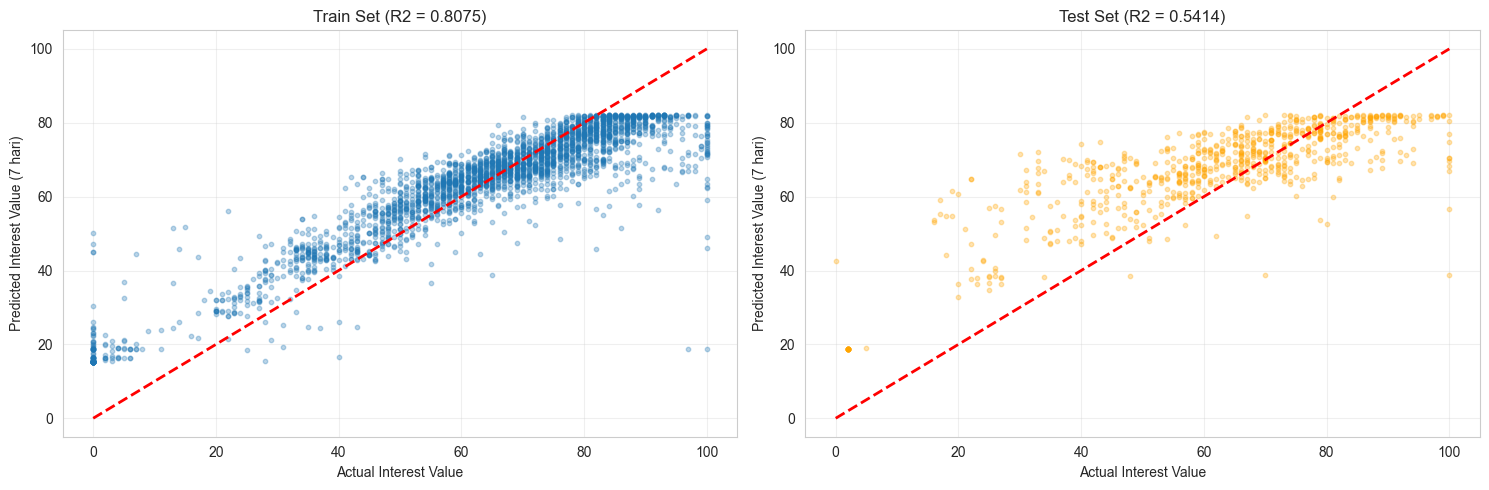

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Train set
axes[0].scatter(y_train, y_pred_train, alpha=0.3, s=10)
axes[0].plot([0, 100], [0, 100], 'r--', lw=2)
axes[0].set_xlabel('Actual Interest Value')
axes[0].set_ylabel('Predicted Interest Value (7 hari)')
axes[0].set_title(f'Train Set (R2 = {train_metrics["R2"]:.4f})')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_pred_test, alpha=0.3, s=10, color='orange')
axes[1].plot([0, 100], [0, 100], 'r--', lw=2)
axes[1].set_xlabel('Actual Interest Value')
axes[1].set_ylabel('Predicted Interest Value (7 hari)')
axes[1].set_title(f'Test Set (R2 = {test_metrics["R2"]:.4f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Sample Test

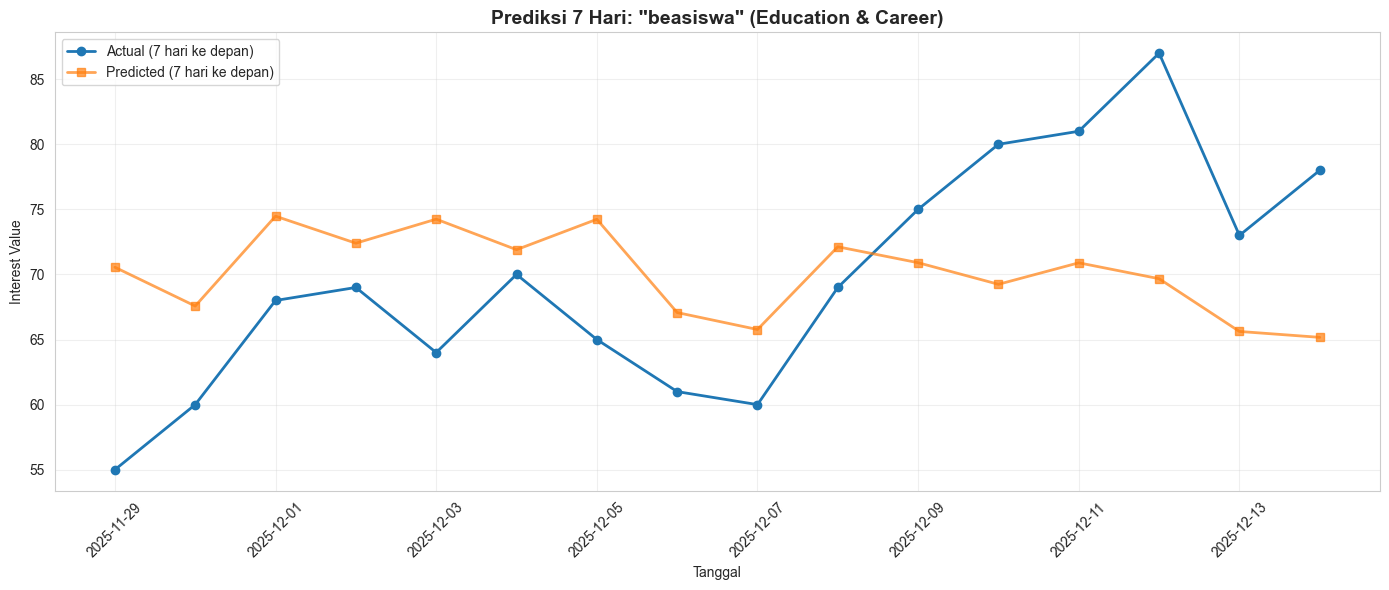

In [15]:
sample_keyword = test_df['keyword'].iloc[1]
sample_category = test_df['category'].iloc[1]

sample_data = test_df[
    (test_df['keyword'] == sample_keyword) & 
    (test_df['category'] == sample_category)
].copy().head(30) 

sample_data['predicted_7d'] = model.predict(
    sample_data[feature_cols + categorical_features],
    num_iteration=model.best_iteration
)

plt.figure(figsize=(14, 6))
plt.plot(sample_data['date'], sample_data['target_7d'], label='Actual (7 hari ke depan)', marker='o', linewidth=2)
plt.plot(sample_data['date'], sample_data['predicted_7d'], label='Predicted (7 hari ke depan)', marker='s', linewidth=2, alpha=0.7)
plt.title(f'Prediksi 7 Hari: "{sample_keyword}" ({sample_category})', fontsize=14, fontweight='bold')
plt.xlabel('Tanggal')
plt.ylabel('Interest Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 10. Save Model

In [19]:
model_path = '../models/daily/lightgbm/lightgbm_daily_7days.txt'
model.save_model(model_path)

metrics = {
    'model': 'LightGBM',
    'forecast_horizon': '7 days',
    'train': train_metrics,
    'test': test_metrics,
    'feature_importance': importance_df.to_dict('records')[:20]
}

import json
with open('../models/daily/lightgbm/lightgbm_daily_7days_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

## 11. Save Model Onnx

In [ ]:
os.makedirs('../models', exist_ok=True)

model_path = '../models/daily/lightgbm/onnx/lightgbm_daily.txt'
model.save_model(model_path)

n_features = X_train.shape[1]
initial_types = [('float_input', FloatTensorType([None, n_features]))]

try:
    onnx_model = onnxmltools.convert.convert_lightgbm(model, initial_types=initial_types)
    
    onnx_path = '../models/daily/lightgbm/onnx/lightgbm_daily.onnx'
    onnxmltools.utils.save_model(onnx_model, onnx_path)
    print(f"  ONNX model saved to: {onnx_path}")
    
except Exception as e:
    print(f"  ERROR exporting to ONNX: {str(e)}")

try:
    if not os.path.exists(onnx_path):
        raise FileNotFoundError("ONNX file not found")
        
    session = ort.InferenceSession(onnx_path)
    input_name = session.get_inputs()[0].name
    
    X_sample_df = X_test.head(5).copy()
    
    for col in X_sample_df.select_dtypes(include=['category']).columns:
        X_sample_df[col] = X_sample_df[col].cat.codes
        
    X_sample = X_sample_df.astype('float32').values
    
    preds_onnx = session.run(None, {input_name: X_sample})[0]
    preds_lgb = model.predict(X_test.head(5))
    
    print(f"  LGB predictions: {preds_lgb[:2]}...")
    print(f"  ONNX predictions: {preds_onnx.flatten()[:2]}...")

    import numpy as np
    if np.allclose(preds_lgb, preds_onnx.flatten(), rtol=1e-3):
        print(" SUCCESS: Predictions match!")
    else:
        print(" WARNING: Prediction mismatch (check categorical encoding)")
        
except Exception as e:
    print(f"  Validation skipped/failed: {str(e)}")


The maximum opset needed by this model is only 8.


  ONNX model saved to: ../models/daily/lightgbm/onnx/lightgbm_daily.onnx
  LGB predictions: [70.55332071 67.57378904]...
  ONNX predictions: [70.55334  67.573746]...
 SUCCESS: Predictions match!


: 